Import Libraries

In [15]:
import os
import itertools
import sys

In [16]:
import sys
import os

sys.path.append("../")

In [17]:
from seaborn import color_palette

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")

In [19]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

In [20]:
import torch_geometric

In [21]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scikitplot as skplt
from sklearn.manifold import TSNE
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

In [25]:
from source.analysis import (
    read_data,
    preprocess,
    get_graph_embeddings,
    pepvecs_2d_plot,
    get_clusters,
    train_model,
    get_subseq_activations
)

from settings import DATA_DIR, AMINO_ACIDS

In [26]:
from source.models import BitterGCN_MixedPool
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

In [27]:
# torch.__version__, torch_geometric.__version__

### Process data

In [28]:
# Settings
hidden_channels = 16
epochs = 10

In [30]:
# Read data and preprocess it
df = read_data("../"+DATA_DIR)
labels = df.bitter
seq = df.seq.values
protien_graphs, encoder = preprocess(df)

### Train the model
Here we are using the GCN having three convolution layers and mixed pooling schema.

BitterGCN: 
 BitterGCN_MixedPool(
  (conv1): GCNConv(20, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)
Epoch: 000, Accuracy: 0.6792
Epoch: 001, Accuracy: 0.7778
Epoch: 002, Accuracy: 0.8169
Epoch: 003, Accuracy: 0.8294
Epoch: 004, Accuracy: 0.8372
Epoch: 005, Accuracy: 0.8529
Epoch: 006, Accuracy: 0.8764
Epoch: 007, Accuracy: 0.8560
Epoch: 008, Accuracy: 0.8842
Epoch: 009, Accuracy: 0.8936


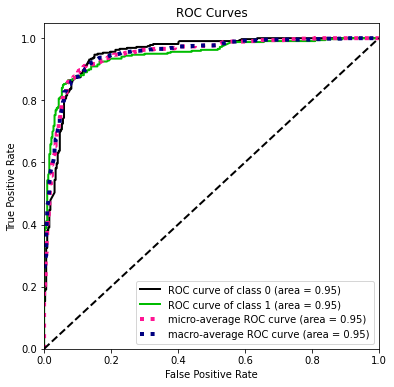

In [35]:
model = BitterGCN_MixedPool(hidden_channels=hidden_channels)
print("BitterGCN: \n", model)
optimizer = Adam(model.parameters(), lr=0.05)

criterion = CrossEntropyLoss()

model, train_loader, test_loader, fig = train_model(model, protien_graphs, optimizer, criterion, epochs=10)
fig

BitterGCN: 
 BitterGCN_MixedPool(
  (conv1): GCNConv(20, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)
Epoch: 000, Accuracy: 0.6792
Epoch: 001, Accuracy: 0.7778
Epoch: 002, Accuracy: 0.8169
Epoch: 003, Accuracy: 0.8294
Epoch: 004, Accuracy: 0.8372
Epoch: 005, Accuracy: 0.8529
Epoch: 006, Accuracy: 0.8764
Epoch: 007, Accuracy: 0.8560
Epoch: 008, Accuracy: 0.8842
Epoch: 009, Accuracy: 0.8936


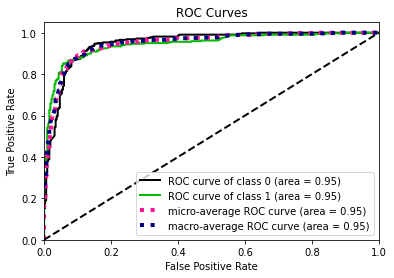

In [ ]:
model = BitterGCN_MixedPool(hidden_channels=hidden_channels)
print("BitterGCN: \n", model)
optimizer = Adam(model.parameters(), lr=0.05)

criterion = CrossEntropyLoss()

model, train_loader, test_loader = train_model(model, protien_graphs, optimizer, criterion, epochs=10)

## Analysis

KL Div: 0.30877381563186646


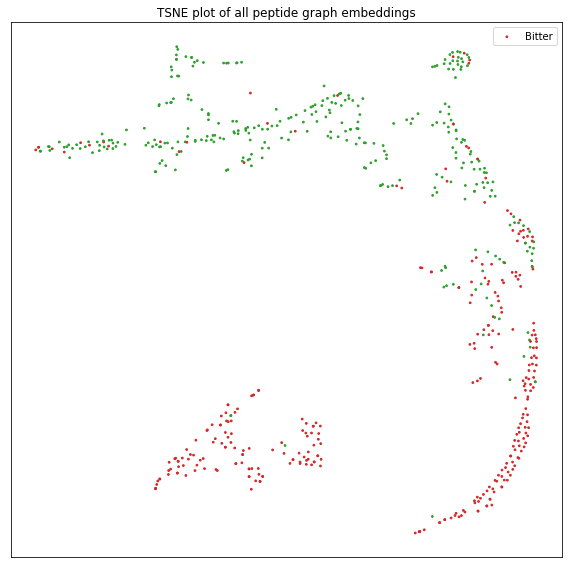

In [38]:
train_graph_embeddings=get_graph_embeddings(model, train_loader, encoder)
test_graph_embeddings=get_graph_embeddings(model, test_loader, encoder)
all_graph_embeddings = test_graph_embeddings + train_graph_embeddings
conv_feats = [i["conv3_feats"].mean(axis=0) for i in all_graph_embeddings]

tsne_embd, descs, labels, fig = pepvecs_2d_plot(all_graph_embeddings, "tsne")
fig

Clusters

In [39]:
from seaborn import scatterplot
from sklearn.cluster import KMeans

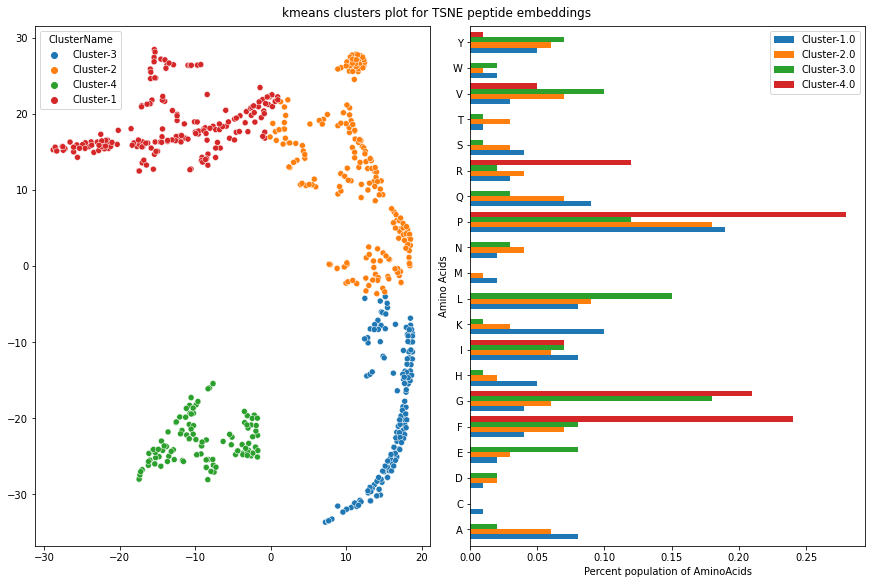

In [44]:
clusters, kmeans_tsne_embd, aminoacid_pop_in_clusters, fig = get_clusters(
    tsne_embd,
    descs,
    all_graph_embeddings,
    method="kmeans",
    method_args={"n_clusters": 4},
    embd_type="TSNE",
)
fig

In [45]:
pop=clusters[['desc', 'Cluster']]
pop.desc = pop.desc.apply(lambda x: [i for i in x])
print("Least Bitter Cluster ----> Most Bitter Cluster")
print("----------------------------------------------")
print(aminoacid_pop_in_clusters.round(2), '\n\n')
print("Accuracy and bitter population in the clusters")
print(clusters.groupby('Cluster').agg(n_bitterpeps=('label', sum), total_peps=('label',len), ModelAcc=('acc','mean')).round(2))

Least Bitter Cluster ----> Most Bitter Cluster
----------------------------------------------
   Cluster-1.0  Cluster-2.0  Cluster-3.0  Cluster-4.0
A         0.08         0.06         0.02         0.00
C         0.01         0.00         0.00         0.00
D         0.01         0.02         0.02         0.00
E         0.02         0.03         0.08         0.00
F         0.04         0.07         0.08         0.24
G         0.04         0.06         0.18         0.21
H         0.05         0.02         0.01         0.00
I         0.08         0.06         0.07         0.07
K         0.10         0.03         0.01         0.00
L         0.08         0.09         0.15         0.00
M         0.02         0.01         0.00         0.00
N         0.02         0.04         0.03         0.00
P         0.19         0.18         0.12         0.28
Q         0.09         0.07         0.03         0.00
R         0.03         0.04         0.02         0.12
S         0.04         0.03         0.01  

## Node level embeddings: All Data 

##### Amino-acid level (Mono-pep)

Text(0.5, 1.0, 'Average BitterGCN embedding outputs for bitter and non-bitter peptide descriptors')

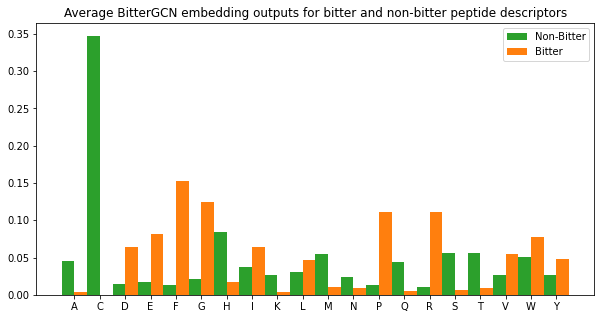

In [47]:
monopeps = get_subseq_activations(all_graph_embeddings, l=1)

# Pos
pos_graphs = [i for i in all_graph_embeddings if i["label"] == 1]
posmonopeps = get_subseq_activations(pos_graphs, l=1)

# Neg
neg_graphs = [i for i in all_graph_embeddings if i["label"] == 0]
negmonopeps = get_subseq_activations(neg_graphs, l=1)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(
    x=np.arange(20) - 0.25,
    height=np.abs(negmonopeps.Imp) / sum(np.abs(negmonopeps.Imp)),
    width=-0.5,
    color=sns.color_palette()[2],
)
ax.bar(
    x=np.arange(20) + 0.25,
    height=np.abs(posmonopeps.Imp) / sum(np.abs(posmonopeps.Imp)),
    width=-0.5,
    color=sns.color_palette()[1],
)
ax.set_xticks(np.arange(20), AMINO_ACIDS)
ax.legend(["Non-Bitter", "Bitter"])
ax.set_title(
    "Average BitterGCN embedding outputs for bitter and non-bitter peptide descriptors"
)

In [21]:
# Di-peptides
subseqs, avg_importance= get_subseq_activations(all_graph_embeddings,l=2)
dipeps = pd.DataFrame([subseqs, avg_importance]).T
dipeps.columns = ['pep', 'Imp']

# Pos Di-peptides
pos_graphs = [i for i in all_graph_embeddings if i['label']==1]
possubseqs, posavg_importance= get_subseq_activations(pos_graphs,l=2)
posdipeps = pd.DataFrame([possubseqs, posavg_importance]).T
posdipeps.columns = ['pep', 'Imp']

# Neg Di-peptides
neg_graphs = [i for i in all_graph_embeddings if i['label']==0]
negsubseqs, negavg_importance= get_subseq_activations(neg_graphs,l=2)
negdipeps = pd.DataFrame([negsubseqs, negavg_importance]).T
negdipeps.columns = ['pep', 'Imp']


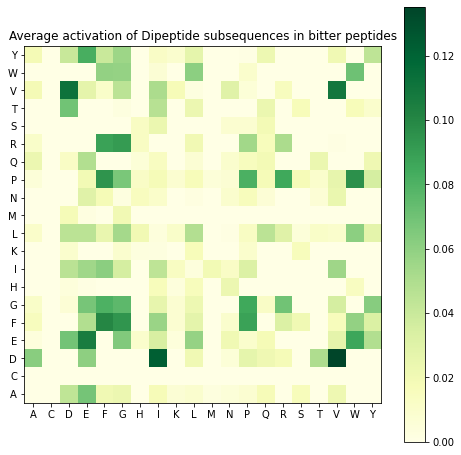

In [22]:
plt.figure(figsize=(8,8))
plt.imshow(np.rot90(np.reshape(np.abs(posdipeps['Imp'].to_list()), (20,20))),cmap='YlGn')
plt.xticks(np.arange(20), AMINO_ACIDS, minor=False)
plt.yticks(np.arange(20), AMINO_ACIDS[::-1])
plt.title("Average activation of Dipeptide subsequences in bitter peptides")
plt.colorbar()


In [23]:
# Tri-peptides
subseqs, avg_importance= get_subseq_activations(all_graph_embeddings,l=3)
tripeps = pd.DataFrame([subseqs, avg_importance]).T.replace(0,np.nan).dropna() # Drop values = 0
tripeps.columns = ['pep', 'Imp']
tripeps.sort_values(by='Imp', ascending=True)

# Pos Tri-peptides
pos_graphs = [i for i in all_graph_embeddings if i['label']==1]
possubseqs, posavg_importance= get_subseq_activations(pos_graphs,l=3)
postripeps = pd.DataFrame([possubseqs, posavg_importance]).T
postripeps.columns = ['pep', 'Imp']

# Neg Tri-peptides
neg_graphs = [i for i in all_graph_embeddings if i['label']==0]
negsubseqs, negavg_importance= get_subseq_activations(neg_graphs,l=3)
negtripeps = pd.DataFrame([negsubseqs, negavg_importance]).T
negtripeps.columns = ['pep', 'Imp']


In [24]:
# Tetra-peptides
subseqs, avg_importance= get_subseq_activations(all_graph_embeddings,l=4)
tetrapeps = pd.DataFrame([subseqs, avg_importance]).T.replace(0,np.nan).dropna() # Drop values = 0
tetrapeps.columns = ['pep', 'Imp']
tetrapeps.sort_values(by='Imp', ascending=False)

# Pos Tetra-peptides
pos_graphs = [i for i in all_graph_embeddings if i['label']==1]
possubseqs, posavg_importance= get_subseq_activations(pos_graphs,l=4)
postetrapeps = pd.DataFrame([possubseqs, posavg_importance]).T
postetrapeps.columns = ['pep', 'Imp']

# Neg Tetra-peptides
neg_graphs = [i for i in all_graph_embeddings if i['label']==0]
negsubseqs, negavg_importance= get_subseq_activations(neg_graphs,l=4)
negtetrapeps = pd.DataFrame([negsubseqs, negavg_importance]).T
negtetrapeps.columns = ['pep', 'Imp']


In [25]:
posallsubpeps = posdipeps.append(posmonopeps).append(postripeps).append(postetrapeps)

posallsubpeps['Imp'] = np.abs(posallsubpeps['Imp'])/np.sum(np.abs(posallsubpeps['Imp']))
posallsubpeps['len'] = posallsubpeps['pep'].apply(len)
posallsubpeps=posallsubpeps[posallsubpeps.Imp!=0]

In [26]:
negallsubpeps = negdipeps.append(negmonopeps).append(negtripeps).append(negtetrapeps)

negallsubpeps['Imp'] = np.abs(negallsubpeps['Imp'])/np.sum(np.abs(negallsubpeps['Imp']))
negallsubpeps['len'] = negallsubpeps['pep'].apply(len)
negallsubpeps=negallsubpeps[negallsubpeps.Imp!=0]

In [27]:
allsubpeps = dipeps.append(monopeps).append(tripeps).append(tetrapeps)

allsubpeps['Imp'] = np.abs(allsubpeps['Imp'])/np.sum(np.abs(allsubpeps['Imp']))
allsubpeps['len'] = allsubpeps['pep'].apply(len)
allsubpeps=allsubpeps[allsubpeps.Imp!=0]

In [28]:
descs_qvals = pd.read_csv('data/Qvalues.csv', sep=', ')
delf=descs_qvals.set_index('Desc').FreeEnergy.to_dict()

In [29]:
def get_q(x): 
    try:
        return np.int(sum([delf[i] for i in x])/len(x))
    except:
        return None

In [30]:
posallsubpeps['Qval'] = posallsubpeps.pep.apply(lambda x: get_q(x))
posallsubpeps['Present'] = posallsubpeps.pep.isin(df.seq)
negallsubpeps['Qval'] = negallsubpeps.pep.apply(lambda x: get_q(x))
negallsubpeps['Present'] = negallsubpeps.pep.isin(df.seq)
allsubpeps['Qval'] = allsubpeps.pep.apply(lambda x: get_q(x))
allsubpeps['Present'] = allsubpeps.pep.isin(df.seq)


In [33]:
posallsubpeps.sort_values('Imp',ascending=False)

,pep,Imp,len,Qval,Present
1844,FPF,0.004427,3,2633.0,True
342,VD,0.004373,2,1115.0,True
37044,FPPF,0.003994,4,2625.0,False
142,ID,0.003961,2,1755.0,True
100885,PPFG,0.00372,4,1962.0,False
...,...,...,...,...,...
2647,HPI,0.000008,3,NaN,False
2966,IKH,0.000008,3,NaN,False
98966,PIKH,0.000005,4,NaN,False
158440,YTDA,0.000005,4,1145.0,False


In [75]:
d1_peps = posallsubpeps[posallsubpeps.len==1].sort_values(by='Imp', ascending=False)[['pep', 'Imp']].apply(lambda x: f"{x['pep']} & {x['Imp']:.5f}", axis=1).to_list()
d1_peps.append('C & -')
d2_peps = posallsubpeps[posallsubpeps.len==2].sort_values(by='Imp', ascending=False)[['pep', 'Imp']].apply(lambda x: f"{x['pep']} & {x['Imp']:.5f}", axis=1).to_list()
d3_peps = posallsubpeps[posallsubpeps.len==3].sort_values(by='Imp', ascending=False)[['pep', 'Imp']].apply(lambda x: f"{x['pep']} & {x['Imp']:.5f}", axis=1).to_list()
d4_peps = posallsubpeps[posallsubpeps.len==4].sort_values(by='Imp', ascending=False)[['pep', 'Imp']].apply(lambda x: f"{x['pep']} & {x['Imp']:.5f}", axis=1).to_list()

for i, d1 in enumerate(d1_peps):
    print(f"{d1} & {d2_peps[i]} & {d3_peps[i]} & {d4_peps[i]} \\\\")

F & 0.00266 & VD & 0.00437 & FPF & 0.00443 & FPPF & 0.00399 \\
G & 0.00217 & ID & 0.00396 & PFF & 0.00357 & PPFG & 0.00372 \\
P & 0.00194 & DV & 0.00362 & VVV & 0.00352 & PPFF & 0.00368 \\
R & 0.00194 & VV & 0.00351 & FPP & 0.00350 & FFPP & 0.00364 \\
E & 0.00142 & EE & 0.00342 & FPR & 0.00344 & FFPG & 0.00361 \\
W & 0.00134 & FF & 0.00323 & FFP & 0.00343 & PFFF & 0.00358 \\
D & 0.00112 & WP & 0.00310 & FPG & 0.00342 & FPGG & 0.00355 \\
I & 0.00111 & FP & 0.00304 & RPF & 0.00341 & GPFF & 0.00354 \\
V & 0.00095 & GF & 0.00304 & FFF & 0.00340 & FRPF & 0.00346 \\
Y & 0.00083 & GR & 0.00295 & FRP & 0.00338 & PFFG & 0.00344 \\
L & 0.00081 & PF & 0.00285 & FFR & 0.00330 & PFFR & 0.00339 \\
H & 0.00030 & FR & 0.00284 & FFG & 0.00320 & GRPF & 0.00337 \\
M & 0.00018 & WE & 0.00279 & PGF & 0.00319 & FFRP & 0.00335 \\
T & 0.00016 & RP & 0.00276 & EEE & 0.00309 & RPFF & 0.00335 \\
N & 0.00015 & PG & 0.00276 & PGR & 0.00304 & FFPR & 0.00335 \\
S & 0.00012 & EY & 0.00266 & GRP & 0.00304 & PPPF & 0.0

In [34]:
from scipy import stats

In [35]:
stats.ttest_ind(posallsubpeps.Imp, negallsubpeps.Imp)

Ttest_indResult(statistic=8.916090972310148, pvalue=9.78967790355256e-19)

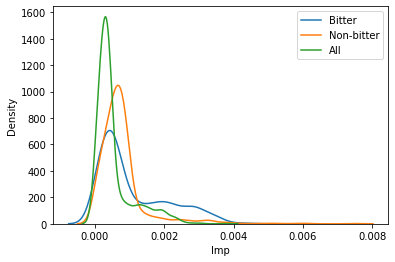

In [36]:
sns.kdeplot(posallsubpeps.Imp.reset_index(drop=True))
sns.kdeplot(negallsubpeps.Imp.reset_index(drop=True))
sns.kdeplot(allsubpeps.Imp.reset_index(drop=True))

plt.legend(['Bitter','Non-bitter','All'])

In [37]:
df['Qval']=df.seq.apply(lambda x: get_q(x))

<AxesSubplot:xlabel='Qval', ylabel='Density'>

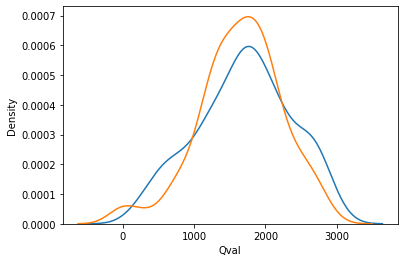

In [38]:
sns.kdeplot(df[df.bitter==1].reset_index(drop=False).Qval)
sns.kdeplot(df[df.bitter==0].reset_index(drop=False).Qval)

In [39]:
clusters['Imp']=clusters.conv3_feats.apply(lambda x: x.mean())

<AxesSubplot:xlabel='Imp', ylabel='Density'>

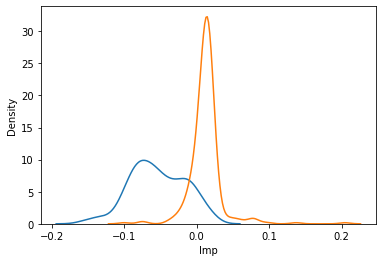

In [40]:
sns.kdeplot(clusters[clusters.label==1].Imp)
sns.kdeplot(clusters[clusters.label==0].Imp)

In [41]:
clusters

,desc,n_nodes,label,pred,conv3_feats,avg_desc_act,TSNE1,TSNE2,Cluster,acc,kmeansbitter,ClusterName,Imp
561,HG,2,0,0,"[[-0.08731226, 0.02543974, -0.12158067, -0.304...","[0.076412365, 0.076412365]",-15.463959,26.86397,1.0,1,3,Cluster-1,0.076412
150,HL,2,0,0,"[[-0.15039615, 0.004667286, -0.11869371, -0.26...","[0.08441653, 0.08441653]",-14.565522,27.207483,1.0,1,3,Cluster-1,0.084417
152,MKG,3,0,0,"[[-0.048982553, -0.0023036376, -0.06150494, -0...","[0.046803236, 0.04316662, 0.03165739]",-15.241479,24.713314,1.0,1,3,Cluster-1,0.040542
566,KAVPYPPQ,8,1,0,"[[0.06064683, -0.011663392, 0.0031109583, -0.1...","[0.005024504, 0.008452724, 0.01867755, 0.01861...",-15.2142,15.070912,1.0,0,4,Cluster-1,0.009825
384,KIYPSFQPQPLIYP,14,0,0,"[[0.055066627, -0.013181321, 0.002876869, -0.1...","[0.005928426, 0.006706778, 0.015995193, 0.0212...",-8.580546,17.432964,1.0,1,3,Cluster-1,0.015640
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,RGPPGGF,7,1,1,"[[0.20819475, 0.27039897, 0.16207689, 0.048988...","[-0.071188025, -0.08903428, -0.08353744, -0.08...",-10.239233,-20.963455,4.0,1,8,Cluster-4,-0.081902
378,GR,2,1,1,"[[0.26199126, 0.29366618, 0.19258435, 0.083802...","[-0.08772232, -0.08772232]",-10.811689,-22.693529,4.0,1,8,Cluster-4,-0.087722
385,VYPFPPGIGG,10,1,1,"[[0.067754865, 0.00027096272, 0.06699507, -0.0...","[-0.013243782, -0.037870467, -0.077905506, -0....",-3.027979,-21.286781,4.0,1,8,Cluster-4,-0.066746
349,YPFPGPI,7,1,1,"[[0.177754, 0.18900125, 0.13978295, 0.03349171...","[-0.057015736, -0.09285597, -0.11420613, -0.10...",-3.468994,-20.564188,4.0,1,8,Cluster-4,-0.066763
